In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

import plotly.express as px
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('python_task_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265403 entries, 0 to 265402
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   device_id    265403 non-null  int64 
 1   device_type  265403 non-null  object
 2   datetime     265403 non-null  object
 3   ev_type      265403 non-null  int64 
 4   adv_type     265403 non-null  object
 5   region_id    265403 non-null  int64 
 6   age          265403 non-null  int64 
 7   gender       265403 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 16.2+ MB


Пропусков в данных нет, нужно закодировать признаки `'device_type', 'adv_type'`.\
C `'datetime'` и `'device_id'` нужно будет еще поработать.


In [4]:
df.describe()

,device_id,ev_type,region_id,age,gender
count,265403.000000,265403.000000,265403.000000,265403.000000,265403.000000
mean,180685.732791,0.015478,1.204941,28.562051,0.932529
std,55776.059535,0.123446,0.403659,15.912911,0.376287
min,100001.000000,0.000000,1.000000,0.000000,0.000000
25%,130828.000000,0.000000,1.000000,21.000000,1.000000
50%,176487.000000,0.000000,1.000000,29.000000,1.000000
75%,228103.500000,0.000000,1.000000,38.000000,1.000000
max,287158.000000,1.000000,2.000000,75.000000,2.000000


#### Посмотрим на распределения признаков

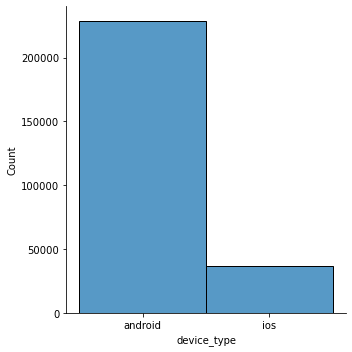

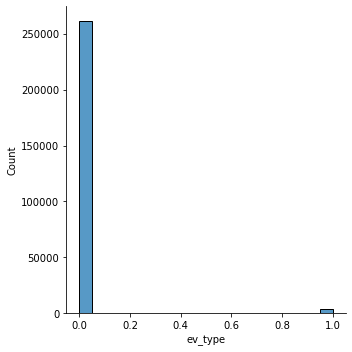

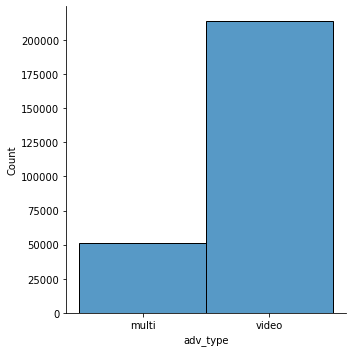

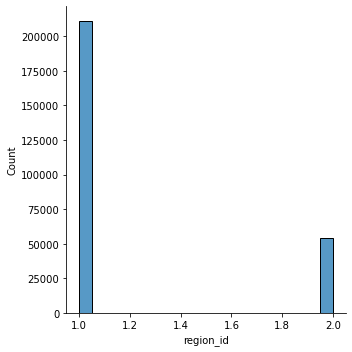

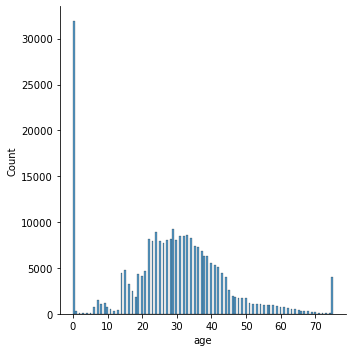

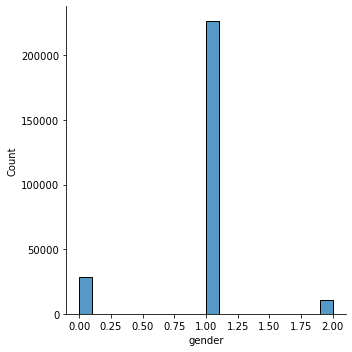

In [5]:
columns = ['device_type', 'ev_type', 'adv_type', 'region_id', 'age', 'gender']

for col in columns:
    data = df[col]
    sns.displot(data)
    plt.show()

Наблюдения по распределениям признаков:
- `device_type` - дисбаланс в сторону android
- `ev_type` - дисбаланс в сторону значения 0 (показы), все праильно, кликов должно быть меньше чем показов
- `adv_type` - дисбаланс в сторону видео
- `region_id` - больше пользователей из региона 1
- `age` - есть выбросы в 0 (скорее всего - нет информации о возрасте), также есть выброс 74+
- `gender` - дисбаланс в сторону женщин, есть 0 - пол не определен
- `device_id` - есть дубли с различным набором параметров, т.е. под одним device_id могут быть люди разных полов и разного возраста/из разных регионов/c разным device_type.

#### Рассмотрим распределения признаков в случае ev_type = 1
возьмем кластер с кликами и рассмотрим его особенности

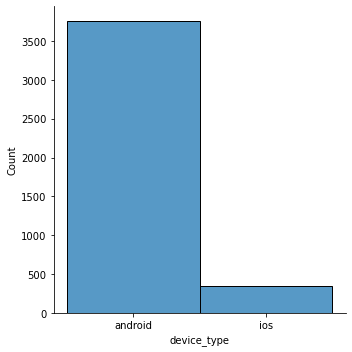

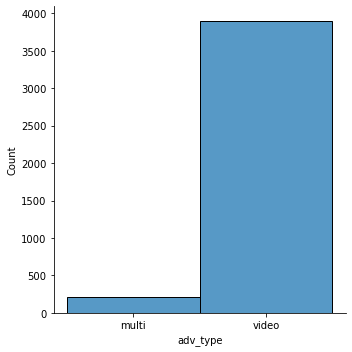

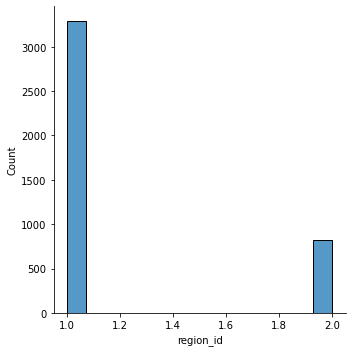

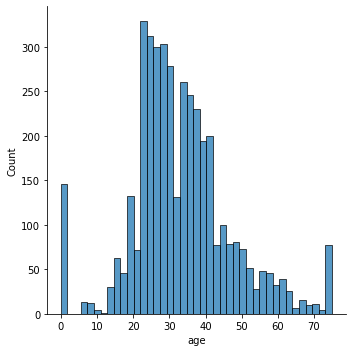

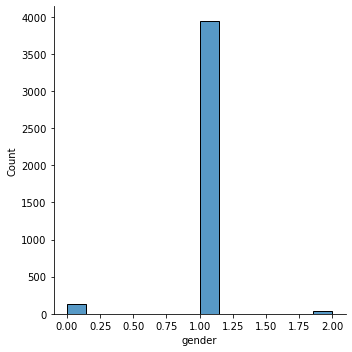

In [6]:
columns = ['device_type', 'adv_type', 'region_id', 'age', 'gender']

for col in columns:
    data = df[df['ev_type'] == 1][col]
    sns.displot(data)
    plt.show()

Пока по характеру распределений сложно сказать о зависимостях, сравнивал распределения признаков с распределением признаков в полном датасете

In [8]:
# Закодируем device_type и adv_type:
dev_type_feat = {'android': 1,
                 'ios': 2}
adv_type_feat = {'video': 1,
                 'multi': 2}

df['device_type'] = df['device_type'].map(dev_type_feat)
df['adv_type'] = df['adv_type'].map(adv_type_feat)

#### Рассмотрим корреляции признаков

<AxesSubplot:>

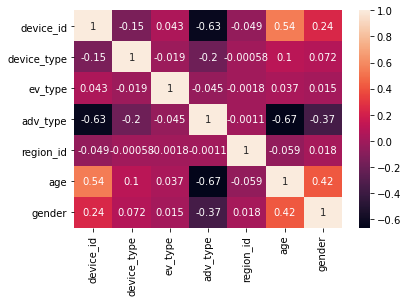

In [9]:
corr_matrix = df.drop(columns='datetime').corr()
sns.heatmap(corr_matrix, annot=True)

<AxesSubplot:>

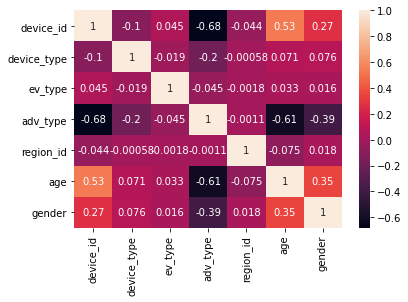

In [77]:
corr_matrix = df[['device_id', 'device_type', 'ev_type', 'adv_type', 'region_id', 'age','gender']].corr('spearman')
sns.heatmap(corr_matrix, annot=True)

Предварительно выделим пары признаков с повышенной корреляцией:
- `'device_id'` и `'adv_type'`: - 0.63 (- 0.68)
- `'device_id'` и `'age'`: 0.54 (0.53)
- `'adv_type'` и`'age'`: -0.67 (-0.61)

#### Подготовка признаков

Из `'device_id'` можно получить признак `'is_new_device_id'` (у признака `'device_id'` есть дубли)

In [11]:
new_device_id = df[['device_id']].groupby('device_id').agg({'device_id':'count'})
new_device_id_list = list(new_device_id[new_device_id['device_id'] == 1].index)
old_device_id_list = list(new_device_id[new_device_id['device_id'] != 1].index)

# новое устройство
df['new_user'] = 0
df.loc[df['device_id'].isin(new_device_id_list) ,'new_user'] = 1

In [12]:
# теперь нужно проставить флаг нового устройства на наблюдениях из old_device_id_list, которые являются самыми первыми 
# по дате отсортированной по возрастанию
index_new_user = df[df['device_id'].isin(old_device_id_list)]\
                .sort_values('datetime').drop_duplicates('device_id', keep='first').index

df.loc[index_new_user,'new_user'] = 1

Разберемся с датой:
- создадим на основе даты несколько признаков (час, день недели, выходной день)
- возможно часы и дни недели нужно закодировать в синусы и косинусы (пока не тестируем)

In [13]:
df['datetime'] = pd.to_datetime(df['datetime'])

df['hour'] = df['datetime'].apply(lambda x: x.hour)
df['weekday'] = df['datetime'].apply(lambda x: x.weekday())
df['is_weekend'] = df['datetime'].apply(lambda x: 1 if x.weekday() in (5, 6) else 0)

In [14]:
df.head()

,device_id,device_type,datetime,ev_type,adv_type,region_id,age,gender,new_user,hour,weekday,is_weekend
0,100001,1,2019-03-01 15:58:02,0,2,2,14,2,1,15,4,0
1,100001,1,2019-03-01 17:13:53,0,2,2,14,2,0,17,4,0
2,100002,1,2019-03-01 23:13:25,0,2,2,0,0,1,23,4,0
3,100002,1,2019-03-01 23:25:06,0,2,2,0,0,0,23,4,0
4,100003,1,2019-03-01 15:27:53,0,2,1,0,0,1,15,4,0


In [15]:
def make_harmonic_features(value, period=24):
    value *= 2 * np.pi / period
    return np.cos(value), np.sin(value)

In [16]:
df['hour_cos'] , df['hour_sin'] = make_harmonic_features(df['hour'], 24)
df['weekday_cos'] ,df['weekday_sin'] = make_harmonic_features(df['hour'], 7)

Уберем признаки, которые нам не нужны для моделирования

In [17]:
del_features = ['device_id',  # собрали признак new_user
                'datetime', # собрали признаки hour, weekday, is_weekend, hour_cos, hour_sin, weekday_cos, weekday_sin
                'ev_type', # по сути, это наш таргет и нежелательно его передавать в модель, пробовал передавать в k-means, получался кластер с 100% ctr
                'hour_cos',
                'hour_sin',
                'weekday_cos',
                'weekday_sin']

df_v1 = df.copy()
df_v1.drop(columns=del_features, inplace=True)

In [18]:
df_v1.head()

,device_type,adv_type,region_id,age,gender,new_user,hour,weekday,is_weekend
0,1,2,2,14,2,1,15,4,0
1,1,2,2,14,2,0,17,4,0
2,1,2,2,0,0,1,23,4,0
3,1,2,2,0,0,0,23,4,0
4,1,2,1,0,0,1,15,4,0


In [19]:
# полные в дублях в данных нам не нужны, уберем их
df_v1_drop_dupl = df_v1.drop_duplicates()

##### Моделирование, ищем кластеры

In [20]:
# стандартизируем признаки
scaler = StandardScaler()
norm_df = pd.DataFrame(scaler.fit_transform(df_v1_drop_dupl), 
                       columns = df_v1_drop_dupl.columns,
                       index = df_v1_drop_dupl.index
                      )

In [21]:
norm_df.head()

,device_type,adv_type,region_id,age,gender,new_user,hour,weekday,is_weekend
0,-0.637035,1.524697,1.390179,-0.980449,2.382014,0.808297,0.332488,0.438216,-0.671119
1,-0.637035,1.524697,1.390179,-0.980449,2.382014,-1.237169,0.657032,0.438216,-0.671119
2,-0.637035,1.524697,1.390179,-1.773741,-2.921319,0.808297,1.630664,0.438216,-0.671119
3,-0.637035,1.524697,1.390179,-1.773741,-2.921319,-1.237169,1.630664,0.438216,-0.671119
4,-0.637035,1.524697,-0.719332,-1.773741,-2.921319,0.808297,0.332488,0.438216,-0.671119


`K-Means`

Найдем оптимальное количество кластеров правилом локтя

In [22]:
distance = []
 
for k in range(1,15):
    estimator = KMeans(n_clusters = k)
    estimator.fit(norm_df)
    distance.append(estimator.inertia_)

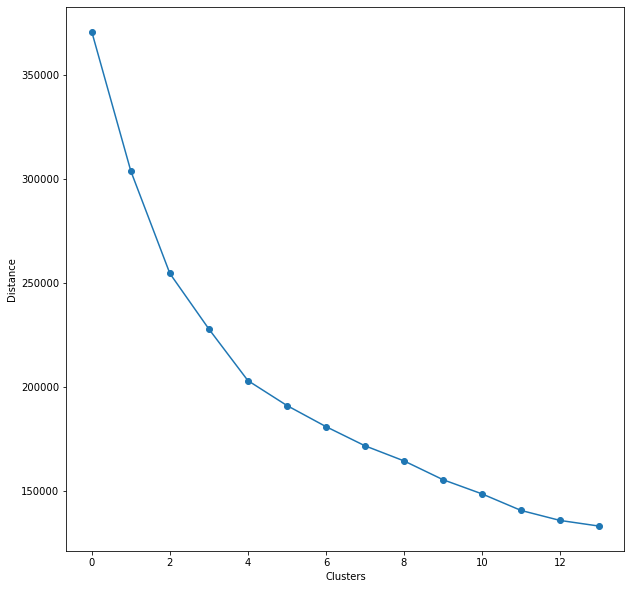

In [23]:
k = range(1,15)
plt.figure(figsize=(10, 10))
plt.xlabel('Clusters')
plt.ylabel('Distance')
plt.plot(distance, '-o')

Возьмем 7 кластеров и посмотрим на разделение кластеров на скаттерплоте

In [39]:
# взяли 7 кластеров
cluster = KMeans(n_clusters=7)
kmeans = cluster.fit_predict(norm_df)

In [40]:
def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

In [41]:
tsne_2d_df = prepare_tsne(2, norm_df, cluster.labels_)

Text(0.5, 1.0, 'K_means')

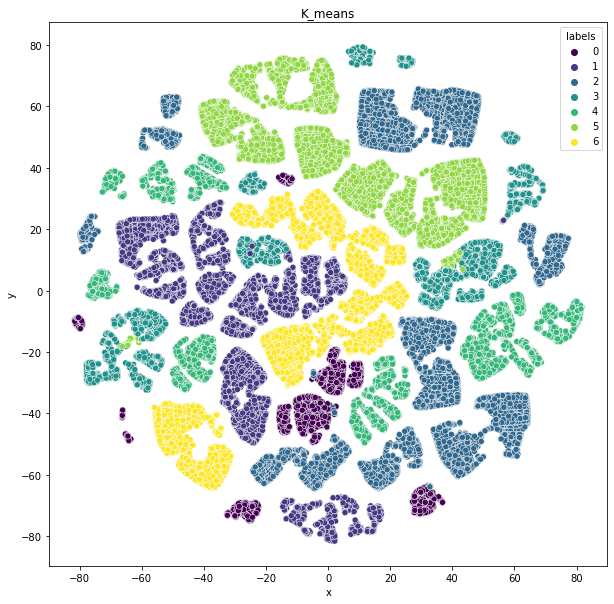

In [42]:
plt.figure(figsize=(10,10))

sns.scatterplot(data=tsne_2d_df, x='x', y='y', hue='labels', palette="viridis")
plt.title('K_means')

Видно, что кластеры разделяются, однако каждый кластер не представляет из себя единое облако в данном пространстве, можно попробовать посмотреть на то, что получилось в отдельных кластерах.

Разделим исходный датасет на получившиеся класетры.

In [43]:
df['kmeans'] = cluster.predict(scaler.transform(df_v1))

!!!! Тут не совсем понял как считать CTR по данной таблице !!!!
1. Складываем в группах по кластерам все по ev_type и делим на количество наблюдений в кластере (если данные могу перезаписываться)
2. Складываем в группах по кластерам все по ev_type и делим на количество 0 наблюдений в кластере

Выбрал 2 вариант

In [44]:
clicks = df[['ev_type', 'kmeans']].groupby('kmeans').sum().rename(columns={'ev_type':'clicks'})
views = df[df['ev_type'] == 0][['ev_type', 'kmeans']].groupby('kmeans').count().rename(columns={'ev_type':'views'})

ctr_df = clicks.merge(views, how='left', left_index=True, right_index=True)
ctr_df['ctr'] = ctr_df['clicks'] / ctr_df['views']

ctr_df.sort_values('ctr', ascending=False)

,clicks,views,ctr
kmeans,,,
5,2009,86896,0.023120
1,521,27947,0.018642
2,1136,72317,0.015709
6,233,23318,0.009992
0,61,14103,0.004325
3,113,26309,0.004295
4,35,10405,0.003364


В качестве самых важных кластеров возьмем 3 кластера c ctr > 1%

#### Рассморим топ-4 по CTR кластера

##### 5-ый кластер

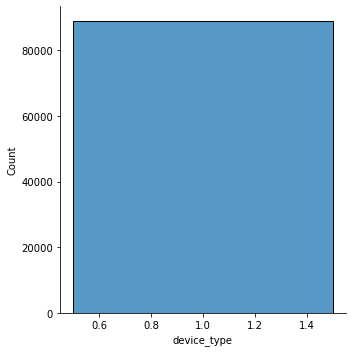

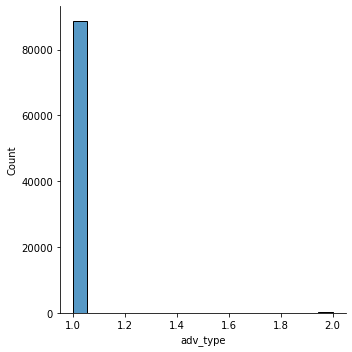

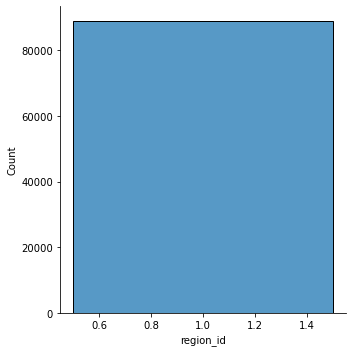

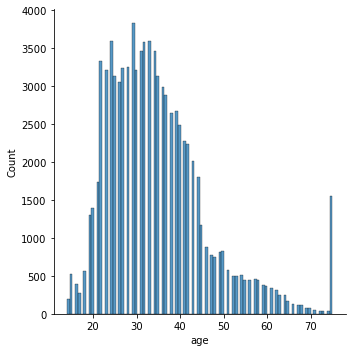

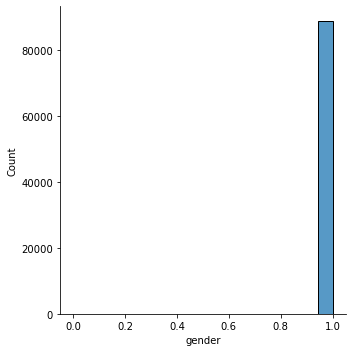

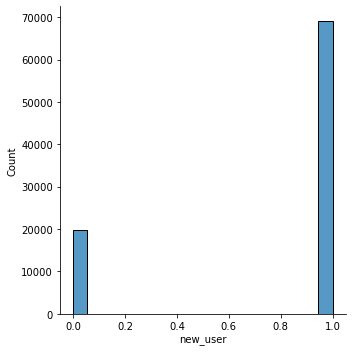

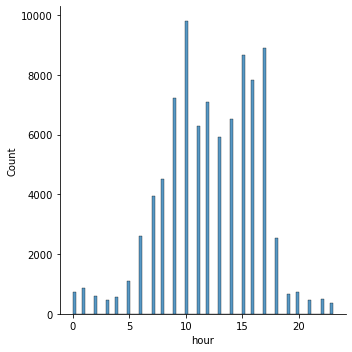

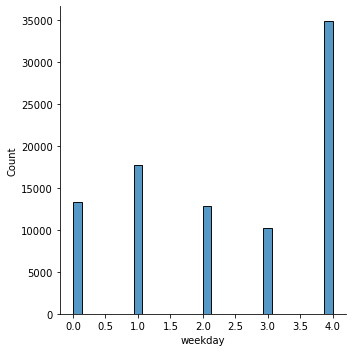

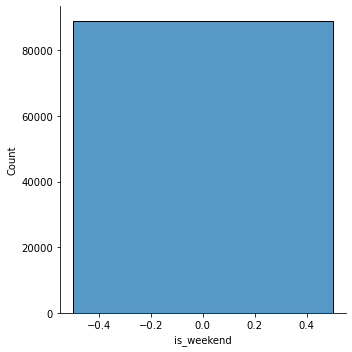

In [45]:
#  выберем признаки для разбора распределений
columns = ['device_type', 'adv_type', 'region_id', 'age', 'gender', 'new_user', 'hour', 'weekday', 'is_weekend']

for col in columns:
    data = df[df['kmeans'] == 5][col]
    sns.displot(data)
    plt.show()

In [46]:
np.quantile(df[df['kmeans'] == 5]['age'], .05), np.quantile(df[df['kmeans'] == 4]['age'], .95)

(20.0, 56.0)

In [48]:
np.quantile(df[df['kmeans'] == 5]['hour'], .05), np.quantile(df[df['kmeans'] == 4]['hour'], .95)

(6.0, 22.0)

<AxesSubplot:>

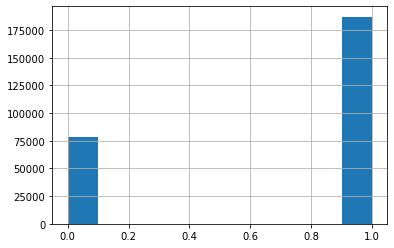

In [49]:
df['new_user'].hist()

- `'device_type'` - пользователи 'android'
- `'adv_type'` - преимущественно видео реклама
- `'region_id'` - регион проживания 1
- `'age'` - возраст (20.0, 56.0)
- `'gender'` - пользователи женщины
- `'new_user'` - несущественно
- `'hour'` - (6.0, 22.0)
- `'weekday'` и `'is_weekend'` -  будни

##### 1-ый кластер

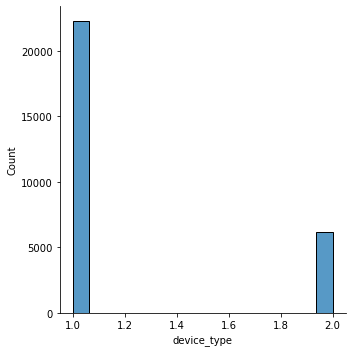

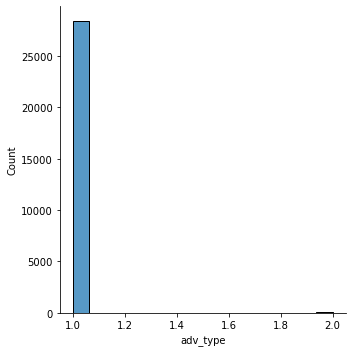

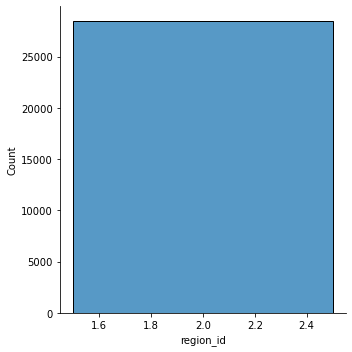

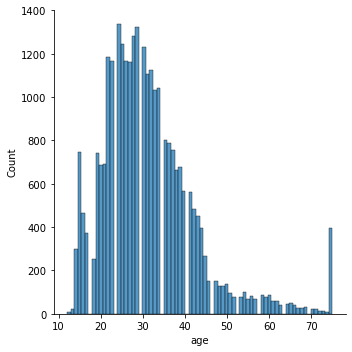

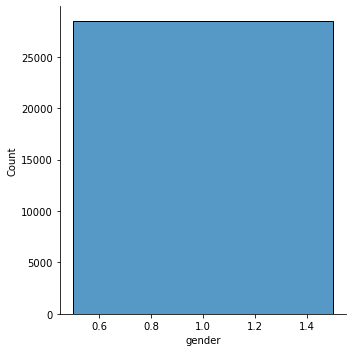

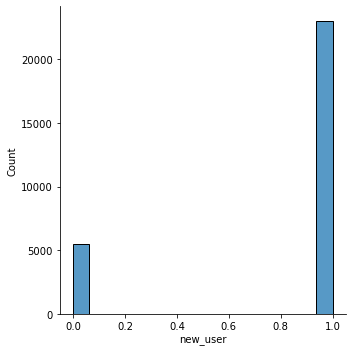

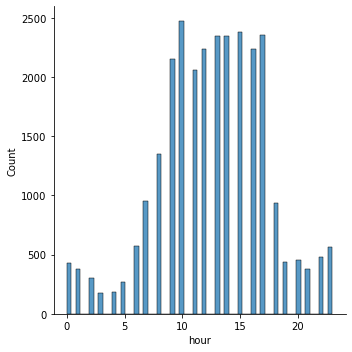

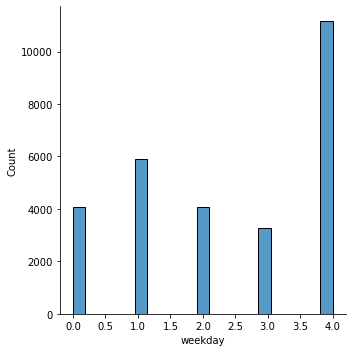

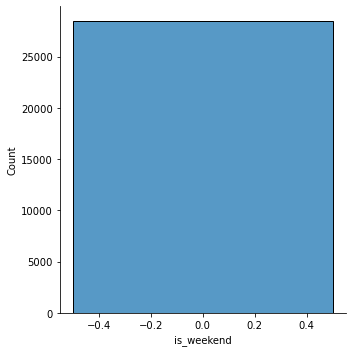

In [53]:
for col in columns:
    data = df[df['kmeans'] == 1][col]
    sns.displot(data)
    plt.show()

In [56]:
np.quantile(df[df['kmeans'] == 1]['age'], .05), np.quantile(df[df['kmeans'] == 4]['age'], .95)

(16.0, 56.0)

In [57]:
np.quantile(df[df['kmeans'] == 1]['hour'], .05), np.quantile(df[df['kmeans'] == 4]['hour'], .95)

(4.0, 22.0)

<AxesSubplot:>

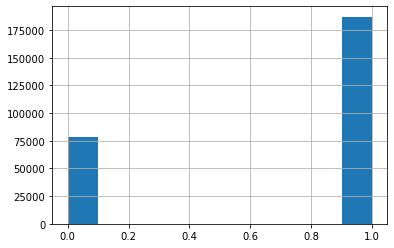

In [326]:
df['new_user'].hist()

- `'device_type'` - несущественно
- `'adv_type'` - преимущественно видео реклама
- `'region_id'` - регион проживания 2
- `'age'` - возраст (16.0, 56.0)
- `'gender'` - пользователи женщины
- `'new_user'` - несущественно
- `'hour'` - (4.0, 22.0)
- `'weekday'` и `'is_weekend'` -  будни

##### 2-ой кластер

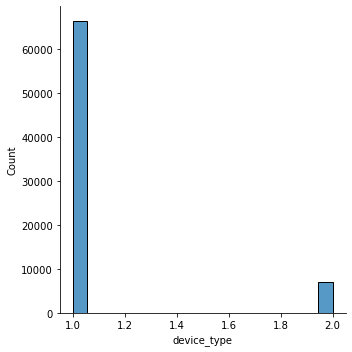

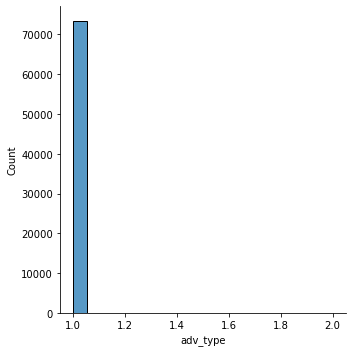

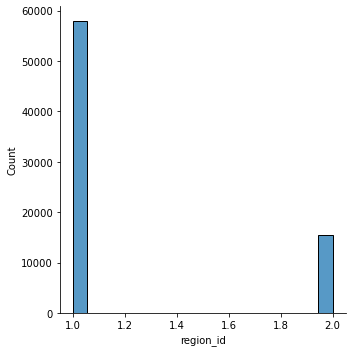

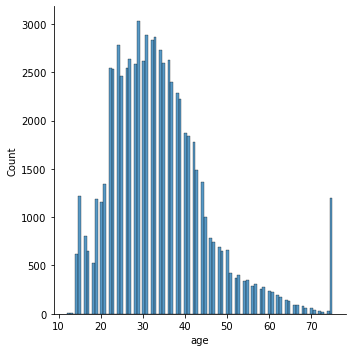

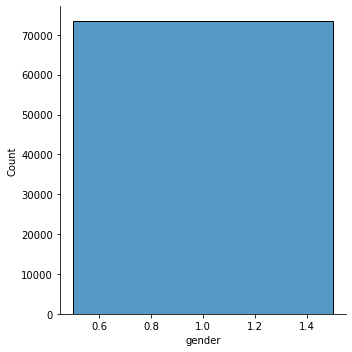

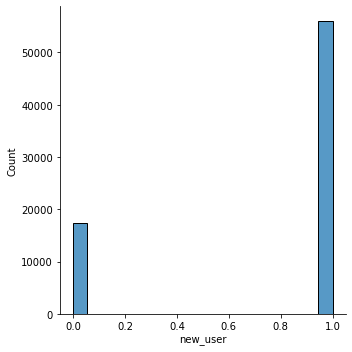

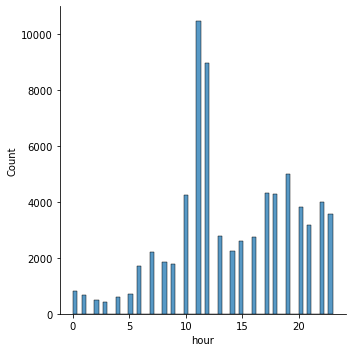

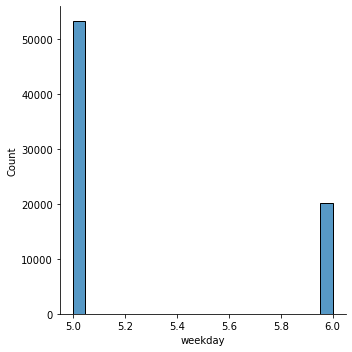

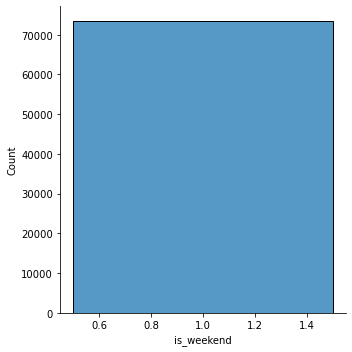

In [58]:
for col in columns:
    data = df[df['kmeans'] == 2][col]
    sns.displot(data)
    plt.show()

In [67]:
df[df['kmeans'] == 2]['adv_type'].value_counts()

1    73371
2       82
Name: adv_type, dtype: int64

In [66]:
df['adv_type'].value_counts()

1    213993
2     51410
Name: adv_type, dtype: int64

In [61]:
np.quantile(df[df['kmeans'] == 2]['age'], .05), np.quantile(df[df['kmeans'] == 4]['age'], .95)

(18.0, 56.0)

In [62]:
np.quantile(df[df['kmeans'] == 2]['hour'], .05), np.quantile(df[df['kmeans'] == 4]['hour'], .95)

(5.0, 22.0)

- `'device_type'` - несущественно
- `'adv_type'` - преимущественно 'video'
- `'region_id'` - несущественно
- `'age'` - возраст (18.0, 56.0)
- `'gender'` - пользователи женщины
- `'new_user'` - несущественно
- `'hour'` - (5.0, 22.0)
- `'weekday'` и `'is_weekend'` -  выходные дни

#### Итоги:

Таргетинг нужно делать на следующие группы пользователей:
1. Пользователи android, женщины, тип рекламы - видео, регион №1, возраст от 20 до 56, время показа с 6:00 до 22:00 в будние дни.
2. Женщины, регион №2, тип рекламы - видео, возраст от 16 до 56, время показа с 4:00 до 22:00 в будние дни.
3. Женщины, возраст от 18 до 56, время показа с 5:00 до 22:00 в выходные дни, тип рекламы - видео.

Рекомендации по времени для основных групп описал выше, общий анализ времени для рекламных кампаний:

Ниже рассмотрел распределения активности по дням недели и по времени в рамках каждого дня недели.\
Основной вывод в том, что активность растет к концу недели - пятница, суббота.\
Проводить рекламные кампании в ночное время не следует!

<AxesSubplot:>

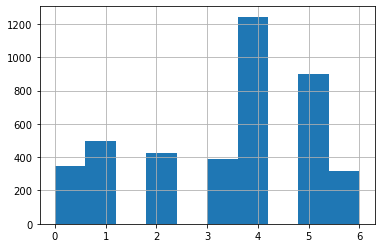

In [68]:
df[df['ev_type'] == 1]['weekday'].hist()

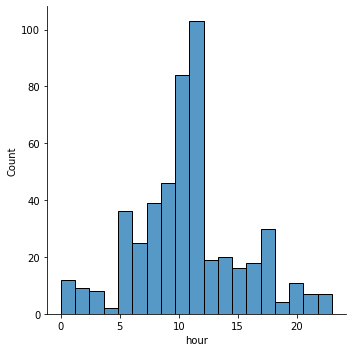

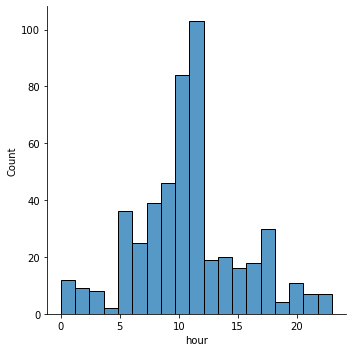

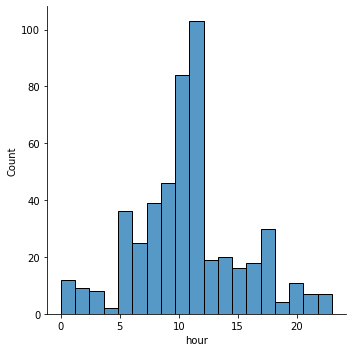

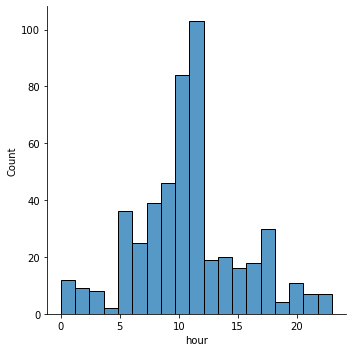

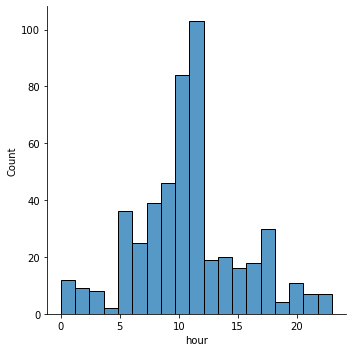

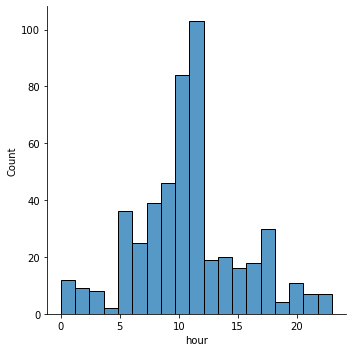

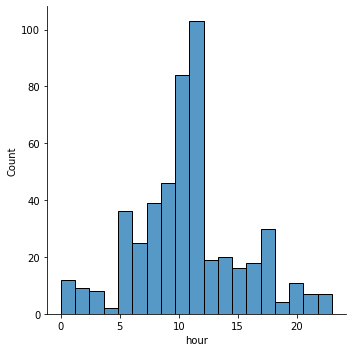

In [69]:
for x in range(0,7):
    data = df[(df['ev_type'] == 1)&(df['weekday'] == 1)]['hour']
    sns.displot(data)
    plt.show()

<AxesSubplot:>

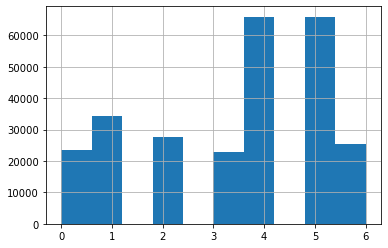

In [70]:
df['weekday'].hist()

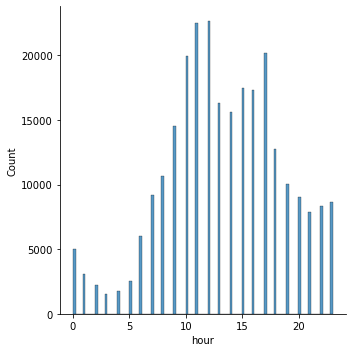

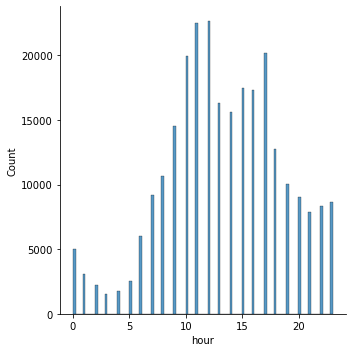

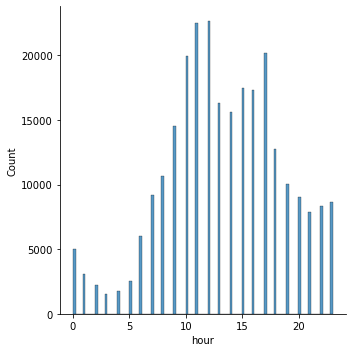

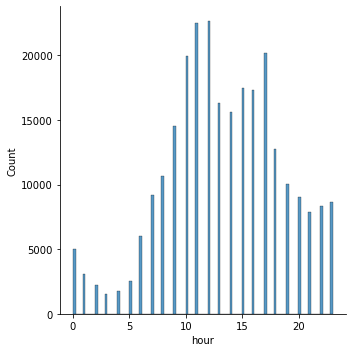

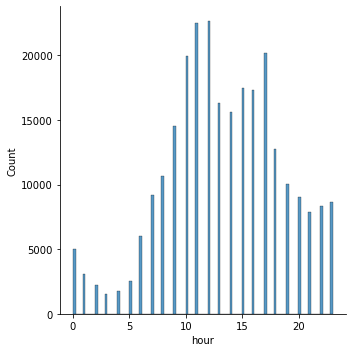

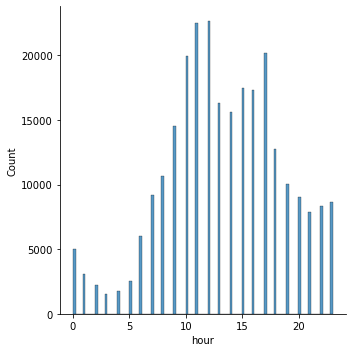

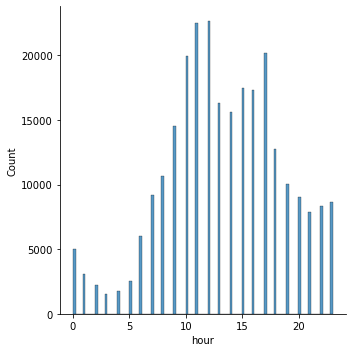

In [71]:
for x in range(0,7):
    data = df['hour']
    sns.displot(data)
    plt.show()